# RL and Advanced DL: Домашнее задание 1

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.  

<details>
  <summary>Правила блекджека достаточно просты;</summary>
  
  ##### Давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:  
  * численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
  * туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
  * игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
  * игрок может совершать одно из двух действий:
    * hit  — взять ещё одну карту;
    * stand — не брать больше карт;
  * если сумма очков у игрока на руках больше 21, он проигрывает (bust);
  * если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
  * после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока;
  * при равенстве очков объявляется ничья (ставка возвращается);
  * в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
</details>

Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.
2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [33]:
from collections import defaultdict
from abc import ABC
from abc import abstractmethod

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [2]:
class Agent(ABC):
    @abstractmethod
    def __init__(self, **params):
        self.name = ""
    
    @abstractmethod
    def action(self, state):
        pass

    def update_Q(self, episode):
        pass


class SimpleStrategy(Agent):
    def __init__(self):
        self.name = "Simple"
    
    def action(self, state):
        return 1 if state[0] <= 18 else 0 


class MonteCarloControl(Agent):
    def __init__(self, gamma, available_actions, epsilon):
        self.name = "MonteCarlo control"
        self.gamma = gamma
        self.available_actions = available_actions
        self.epsilon = epsilon

        self.Q = defaultdict(lambda: np.zeros(self.available_actions))
        self.Nsa = defaultdict(lambda: defaultdict(lambda: 0))
        self.pi = defaultdict(lambda: 0)  

    def action(self, state):
        if np.random.choice(np.arange(2), p=[1 - self.epsilon, self.epsilon]):
            action = self.pi[state] 
        else:
            action = np.random.choice(self.available_actions)  
        return action

    def update_Q(self, episode):
        G = 0
        for t in reversed(range(episode.length)):
            self.Nsa[episode.state[t]][episode.action[t]] += 1
            alpha = (1 / (self.Nsa[episode.state[t]][episode.action[t]] + 1))
            G = self.gamma * G + episode.reward[t]
            self.Q[episode.state[t]][episode.action[t]] += alpha * (G - self.Q[episode.state[t]][episode.action[t]])
            self.pi[episode.state[t]] = self.Q[episode.state[t]].argmax()

In [3]:
class Episode:
    def __init__(self):
        self.state = []
        self.action = []
        self.reward = []
        self.length = 0

    def add_step(self, state, action, reward):
        self.state.append(state)
        self.action.append(action)
        self.reward.append(reward)
        self.length += 1

    def get_total_reward(self):
        return sum(self.reward)

In [4]:
class BlackjackSimulation():
    def __init__(self, env, n, agent):
        self.env = env
        self.n = n
        self.agent = agent
        self.win_rates = []
        self.total_rewards = []
           
    def simulate_episode(self):
        episode = Episode()
        done = False
        state = self.env.reset()
        
        while not done:
            action = self.agent.action(state)
            new_state, reward, done, desc = self.env.step(action)
            episode.add_step(state, action, reward)
            state = new_state
            
        self.agent.update_Q(episode)   
        return episode
    
    def simulation(self, get_report=True):
        wins = 0
        total_reward = 0
        for i in range(1, self.n + 1):
            episode = self.simulate_episode()
            total_reward += episode.get_total_reward()
            if episode.get_total_reward() == 1:
                wins += 1
            self.total_rewards.append(total_reward / i)
            self.win_rates.append(wins / i) 
        if get_report:
            self._get_report()
        return np.mean(self.total_rewards)

    def _get_report(self):
        print(f"{self.agent.name} agent average reward: {np.mean(self.total_rewards)}, win rate: {np.mean(self.win_rates)}")
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax2 = ax.twinx()
        ax2.grid(None)
        line1 = ax.plot(np.arange(100, self.n), self.total_rewards[100:], label=f"{self.agent.name} agent average total reward", color="C0")
        line2 = ax2.plot(np.arange(100, self.n), self.win_rates[100:], label=f"{self.agent.name} agent win rate", color="C1")
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc=0)
        ax.set_xlim((100, self.n))
        ax.set_xlabel("Episods")


In [5]:
from blackjack import BlackjackEnv
env = BlackjackEnv(natural=True)

Simple agent average reward: -0.17283518564857484, win rate: 0.3235573633082633


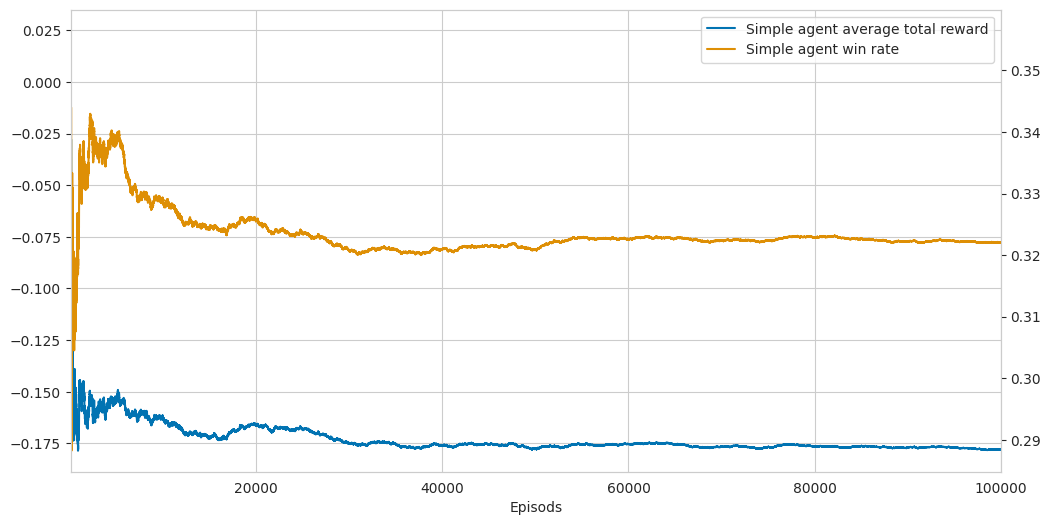

In [7]:
simple_strategy = SimpleStrategy()
black_jack = BlackjackSimulation(env, 100000, simple_strategy)
black_jack.simulation();

Попробуем найти оптимальные параметры:

In [57]:
def greed_searh_params(env, n=10000, gammas=np.linspace(0.1, 1, 10), epsilons=np.linspace(0, 1, 6)):
    best_reward = -1
    best_gamma = 0
    best_epsilon = 0

    XX, YY = np.meshgrid(gammas, epsilons)
    reward = np.zeros_like(XX)

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            monte_carlo = MonteCarloControl(gamma, env.action_space.n, epsilon)
            black_jack = BlackjackSimulation(env, n, monte_carlo)
            mean_reward = black_jack.simulation(get_report=False)
            reward[i][j] = mean_reward
            if mean_reward > best_reward:
                best_reward = mean_reward
                best_gamma = gamma
                best_epsilon = epsilon

    print(f"Best average reward: {best_reward} (gamma: {best_gamma}, epsilon: {best_epsilon})")
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(XX, YY, reward, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0,
                        antialiased=False, vmin=np.nanmin(reward), vmax=np.nanmax(reward))
    ax.set_xlabel('Gamma')
    ax.set_ylabel('Epsilon')
    ax.set_zlabel('Reward')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    return best_gamma, best_epsilon

In [58]:
gammas = np.append(np.arange(0.1, 0.8, 0.1), np.linspace(0.8, 1, 11))

Best average reward: -0.06932610608022154 (gamma: 0.30000000000000004, epsilon: 1.0)


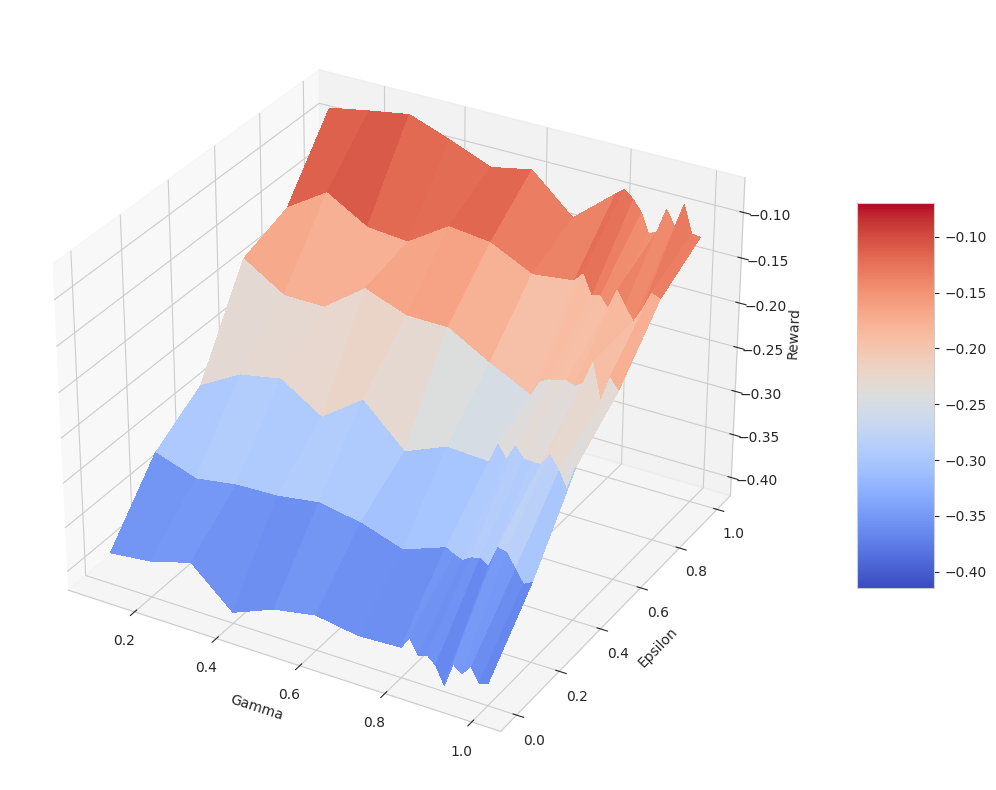

In [59]:
best_gamma, best_epsilon = greed_searh_params(env, gammas=gammas)

MonteCarlo control agent average reward: -0.06160582812592873, win rate: 0.37307709247361714


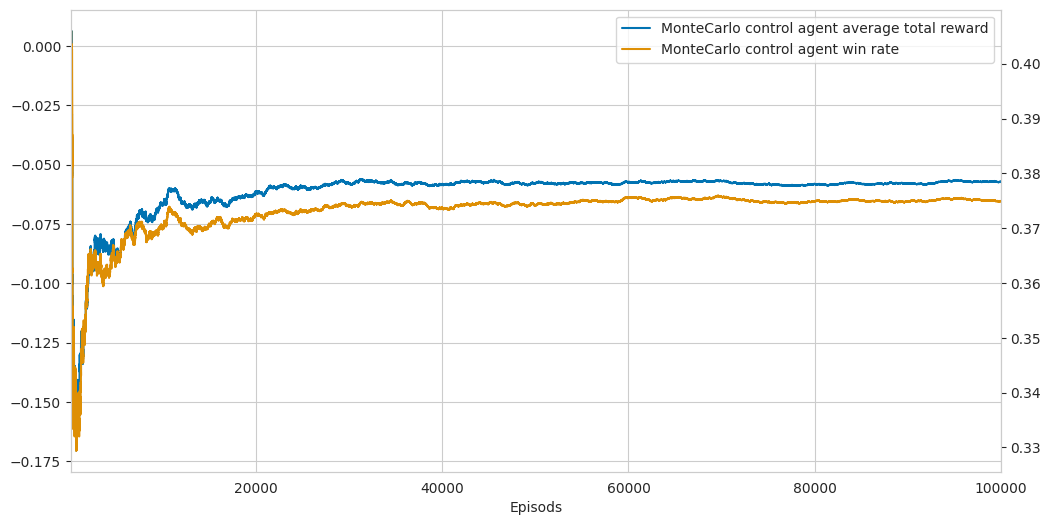

In [60]:
monte_carlo = MonteCarloControl(best_gamma, env.action_space.n, best_epsilon)
black_jack = BlackjackSimulation(env, 100000, monte_carlo)
black_jack.simulation();

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности.  
Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
* **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [61]:
from blackjack import BlackjackDoubleEnv
env2 = BlackjackDoubleEnv(natural=True)

Best average reward: -0.09495636105203774 (gamma: 0.4, epsilon: 1.0)


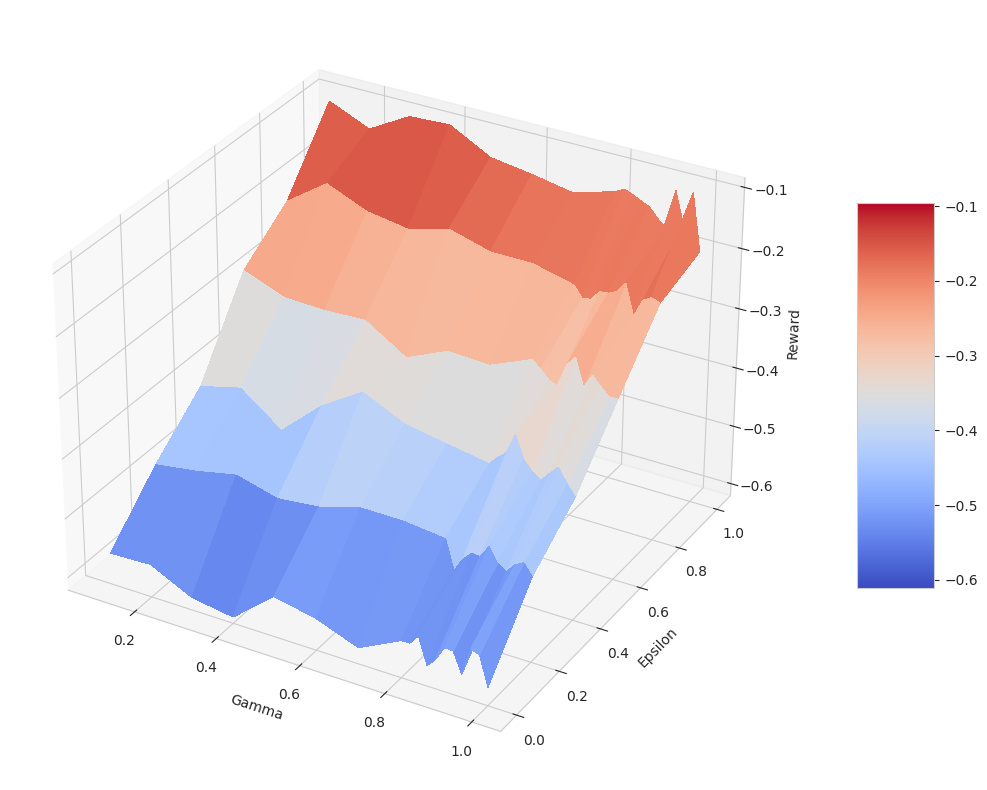

In [62]:
best_gamma, best_epsilon = greed_searh_params(env2, gammas=gammas)

MonteCarlo control agent average reward: -0.08788288383457316, win rate: 0.34315653587938943


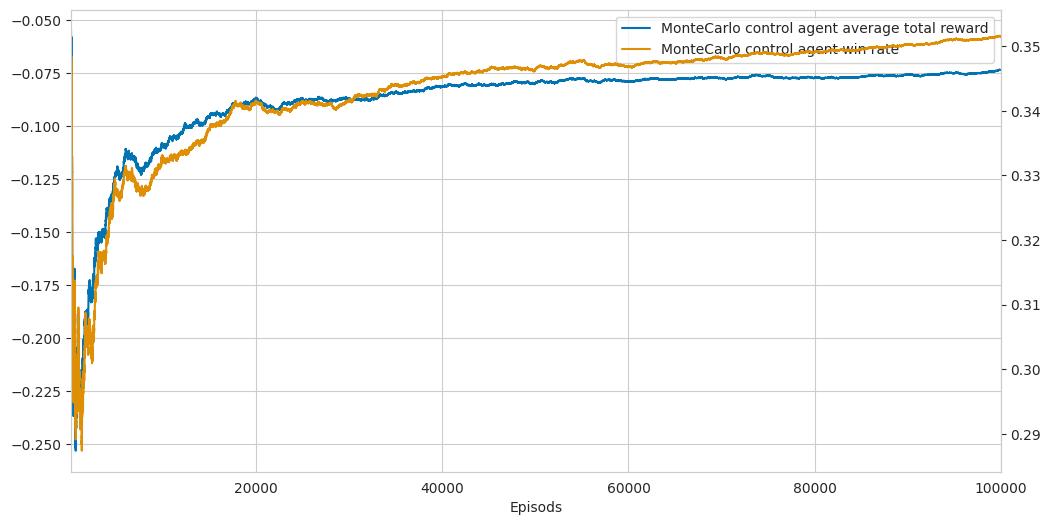

In [63]:
monte_carlo = MonteCarloControl(best_gamma, env2.action_space.n, best_epsilon)
black_jack = BlackjackSimulation(env2, 100000, monte_carlo)
black_jack.simulation();

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
  
6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).  
7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.
 

In [69]:
from blackjack import BlackjackCountingEnv
env3 = BlackjackCountingEnv(natural=True, num_decks=4)

Best average reward: -0.15865408703665762 (gamma: 0.8400000000000001, epsilon: 1.0)


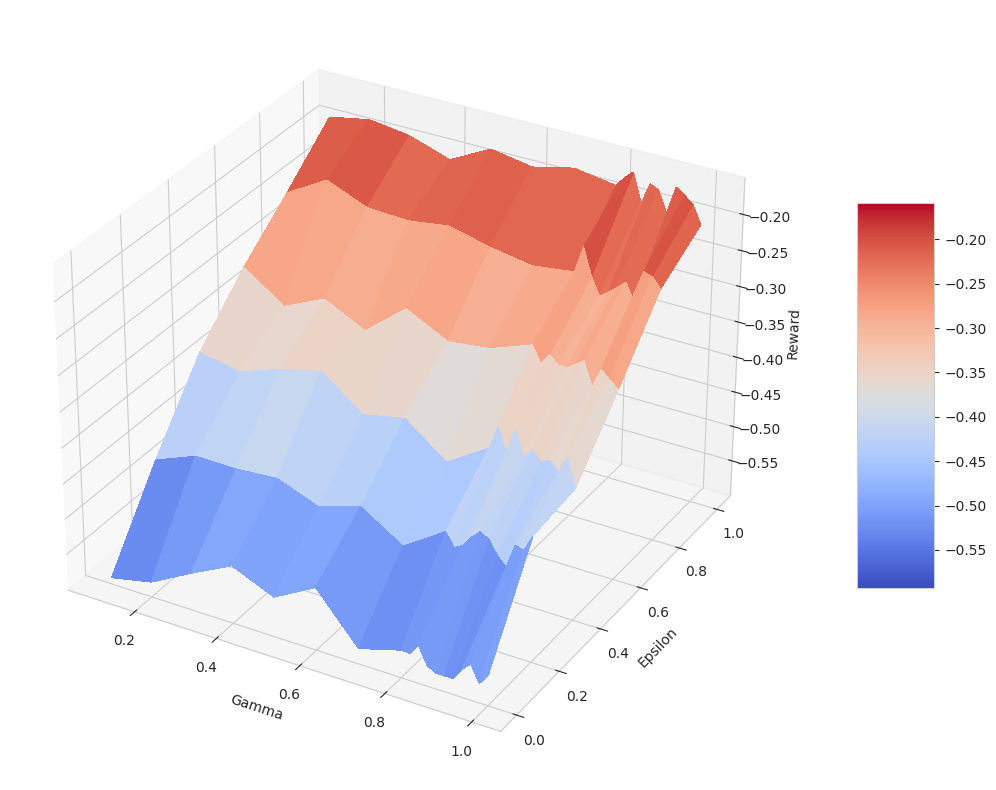

In [65]:
best_gamma, best_epsilon = greed_searh_params(env3, gammas=gammas)

MonteCarlo control agent average reward: -0.15918418745809745, win rate: 0.31448420530669297


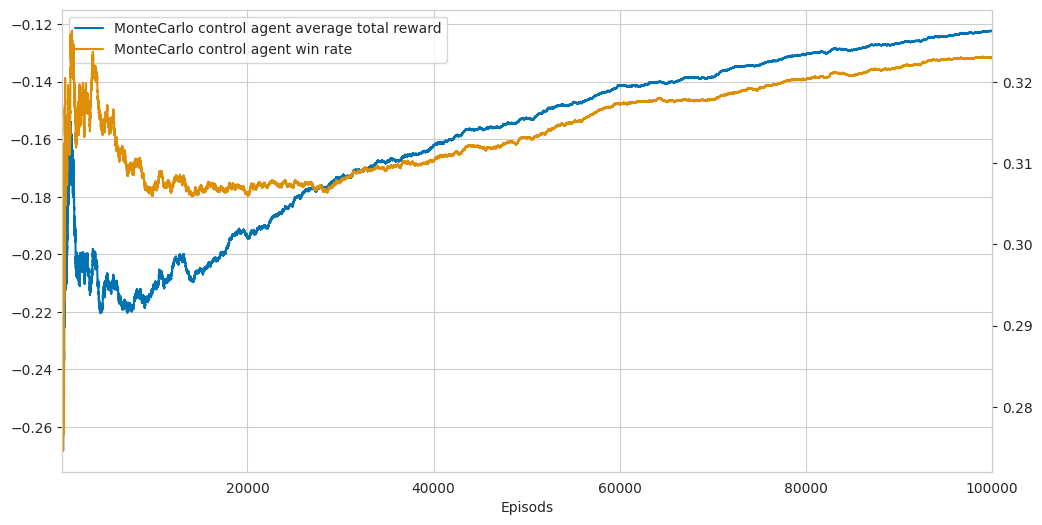

In [70]:
monte_carlo = MonteCarloControl(best_gamma, env3.action_space.n, best_epsilon)
black_jack = BlackjackSimulation(env3, 100000, monte_carlo)
black_jack.simulation();

Обыграть казино не получилось, но некоторые стратегии по крайней мере, позволяют не сильно "проиграться" в казино.